# PROYECTO: ALZHEIMER ---> INTERPRETABILIDAD

#  0. Librerias e Inicialización

In [1]:
# Librerias específicas de Tratamiento de imágenes RMI y fRMI
import nibabel as nib

from nilearn import plotting, image, datasets
from nilearn.datasets import load_mni152_template
from nilearn.image import resample_to_img, threshold_img, get_data, coord_transform

In [2]:
from lime import lime_image
from skimage.segmentation import slic, mark_boundaries

In [3]:
# Librerias de Sistema
import os
import time

# Gestión de imágenes y Gráficos
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

# Pandas
import pandas as pd

# Numpy
import numpy as np

# Librerías Torch
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import  DataLoader, Dataset, Subset

# Librerías Utilidades para Torch
from torchinfo import summary

# Librerias de Scikit-Learn
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, roc_curve,
    classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

from scipy.ndimage import center_of_mass

from functools import reduce


In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def mem_stats():
    mem = torch.cuda.memory_allocated() / (1024 ** 2)
    peak = torch.cuda.max_memory_allocated() / (1024 ** 2)
    mem_reserved = torch.cuda.memory_reserved() / (1024 ** 2) 
    print('Torch Version:', torch.__version__)
    print('Device:', torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    print(f"GPU Memory -->  Usage: {mem:.2f} MB | Peak: {peak:.2f} MB| Reserved: {mem_reserved:.2f} MB")

mem_stats()

Torch Version: 2.5.1
Device: cuda
GPU Memory -->  Usage: 0.00 MB | Peak: 0.00 MB| Reserved: 0.00 MB


# 1. Dataset
---

## 1.1. Clase Dataset

In [5]:

class CustomNIIDataset(Dataset):
    def __init__(self, 
                 device, 
                 path_base, 
                 path_filedata, 
                 binaria = True,
                 transform = None, 
                 output_shape = (128, 128, 128),
                 filter_target = None,
                 arquitecture = 'CNN',
                 segment = False,
                 segment_base = (0,0,0),
                 segment_size = 16,
                 data_memory = False
                ):
        self.path_base   = path_base
        self.df_targets = pd.read_csv(path_filedata)
        self.transform  = transform
        self.binaria = binaria
        self.filter_target = filter_target
        self.arquitecture = arquitecture
        self.segment = segment
        self.segment_base = segment_base
        self.segment_size = segment_size
        self.data_memory = data_memory

        # Cargar todos los paths
        self._all_paths = []
        self._all_targets = []
        self._all_types = []
        self._all_ID = []
        self._all_hoja = []

        self._load_all_samples()

        # Inicialización: dataset sin filtrar
        self.output_shape = output_shape  # ( H, W, D)
        self.device = device
        
    def _load_all_samples(self):
        n_subjects = 0
        n_seasons = 0    
        n_samples = 0
        n_samples_added = 0
        n_error = 0
        for subj in os.listdir(self.path_base):
            subj_path = os.path.join(self.path_base, subj)
            if not os.path.isdir(subj_path):
                continue

            try:
                subj_num = int(subj.split('-')[1])
            except:
                continue
            
            targets_min = self.df_targets['target'].min()
            n_subjects += 1
            for ses in os.listdir(subj_path):
                n_seasons += 1
                ses_path = os.path.join(subj_path, ses)
                if not os.path.isdir(ses_path):
                    continue

                try:
                    hoja_num = int(ses.split('wave')[1])
                except:
                    continue

                mask = (self.df_targets['S#'] == subj_num) & (self.df_targets['hoja'] == hoja_num)
                if mask.sum() == 0:
                    #print('Warning: No target found for this sample:', ses_path) 
                    n_error +=1
                    continue
                                
                targets = self.df_targets.loc[mask, 'target'].values
                if (len(targets)>0):
                    target = targets[0]
                    if (self.filter_target is not None and target in self.filter_target):
                        add_sample = False
                    else:
                        add_sample = True
                    target = target - targets_min
                    if self.binaria:
                        # Binarizar target
                        target = 1 if target < 3 else 0

                for tipo in os.listdir(ses_path):
                    tipo_path = os.path.join(ses_path, tipo)
                    if not os.path.isdir(tipo_path):
                        continue

                    for fname in os.listdir(tipo_path):
                        if fname.endswith('.nii') or fname.endswith('.nii.gz'):
                            n_samples +=1
                            if add_sample:
                                n_samples_added += 1
                                path = os.path.join(tipo_path, fname)
                                self._all_paths.append(path)
                                self._all_targets.append(target)
                                self._all_types.append(tipo)
                                self._all_ID.append(subj_num)
                                self._all_hoja.append(hoja_num)
        
        print('\nTotal Pacientes en la base de Datos:    ', n_subjects, ' (Seasons =',n_seasons,')')
        print('Muestras Descartadas por falta de Target: ', n_error)
        print('Total Muestras en la base de datos:       ', n_samples)
        if self.filter_target is not None:
            print('--> Dataset Filtrado por Targets Eliminados=', self.filter_target,':',n_samples_added, 'muestras')
   
    def filter_clase(self, clase):
        """Filtra self.paths conservando solo aquellos cuyo nombre de archivo contiene la clase de archivo"""
        indices_filtrados = [
                               i for i, path in enumerate(self.paths) if clase in os.path.basename(path)
                          ]
        
        self.paths   = [self.paths[i] for i in indices_filtrados]
        self.targets = [self.targets[i] for i in indices_filtrados]
        self.types   = [self.types[i] for i in indices_filtrados]
        self.ID      = [self.ID[i] for i in indices_filtrados]
        self.hoja    = [self.hoja[i] for i in indices_filtrados]
        print(f'--> Dataset filtrado por clase="{clase}": {len(self.paths)} muestras.')
        
    def filter_tipo(self, tipos):
        """Filtra el dataset para incluir solo ciertos tipos (str o lista de str)"""
        if isinstance(tipos, str):
            tipos = [tipos]  # convertir a lista si es string único

        indices = [i for i, t in enumerate(self._all_types) if t in tipos]

        self.paths   = [self._all_paths[i] for i in indices]
        self.targets = [self._all_targets[i] for i in indices]
        self.types   = [self._all_types[i] for i in indices]
        self.ID      = [self._all_ID[i] for i in indices]
        self.hoja    = [self._all_hoja[i] for i in indices]
        
        print(f'--> Dataset filtrado por tipos={tipos}: {len(self.paths)} muestras.')

    def reset_filter(self):
        """Restaura el dataset completo (sin filtros)"""
        self.paths = list(self._all_paths)
        self.targets = list(self._all_targets)
        self.types = list(self._all_types)
        self.ID = list(self._all_ID)
        self.hoja = list(self._all_hoja)

        print(f'--> Filtro reseteado: {len(self.paths)} muestras activas.')


    def resize_or_pad(self, data):
        #data = torch.from_numpy(data).unsqueeze(0).float()  # [1, H, W, D]

        # Resize con interpolación si tamaño es diferente
        data = F.interpolate(data.unsqueeze(0), size=self.output_shape, mode='trilinear', align_corners=False)
        data = data.squeeze(0) 
        return data  # [1, D, H, W]

    def preload_all_to_gpu(self):
        """Carga todas las muestras en memoria GPU"""
        self._data_gpu = []
        mem = torch.cuda.memory_allocated() / (1024 ** 2)
        peak = torch.cuda.max_memory_allocated() / (1024 ** 2)
        mem_reserved = torch.cuda.memory_reserved() / (1024 ** 2) 
        print(f"GPU Memory Before -->  Usage: {mem:.2f} MB | Peak: {peak:.2f} MB| Reserved: {mem_reserved:.2f} MB")
        for idx in range(len(self.paths)):
            print('.', end='')
            path = self.paths[idx]
            try:
                nii_img = nib.load(path)
                data = nii_img.get_fdata(dtype=np.float32)
    
                # Normalización z-score
                data = (data - np.mean(data)) / (np.std(data) + 1e-8)
                data = torch.from_numpy(data).unsqueeze(0).float()
                
                if torch.isnan(data).any():
                    raise ValueError(f' El tensor contiene NaNs en el archivo: {path}')
                if torch.isinf(data).any():
                    raise ValueError(f' El tensor contiene Inf en el archivo: {path}')
            except:
                print('archivo corrupto:',path)
                path = self.paths[0]
                target = self.targets[0]
                tipo = self.types[0]
                nii_img = nib.load(path)
                data = nii_img.get_fdata(dtype=np.float32)
    
            sbase = [b * self.segment_size for b in self.segment_base]
            if self.segment:
                for ix, base in enumerate(sbase):
                    if (base + self.segment_size > data.shape[ix+1]):
                        sbase[ix] = data.shape[ix+1] - self.segment_size
                    if sbase[ix] < 0:
                        sbase[ix] = 0
                    
                W0, H0, D0 = sbase
                S = self.segment_size
                data = data[:,W0:W0+S, H0:H0+S, D0:D0+S]
            self._data_gpu.append(data) 

        self._data_gpu = torch.stack(self._data_gpu).to(self.device)
        print('\nDatos cargados en Memoria:',len(self.paths))
        mem = torch.cuda.memory_allocated() / (1024 ** 2)
        peak = torch.cuda.max_memory_allocated() / (1024 ** 2)
        mem_reserved = torch.cuda.memory_reserved() / (1024 ** 2) 
        print(f"GPU Memory After -->  Usage: {mem:.2f} MB | Peak: {peak:.2f} MB| Reserved: {mem_reserved:.2f} MB")

    def get_RawData(self, idx):
        path   = self.paths[idx]
        nii_img = nib.load(path)
        return nii_img
        
    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path   = self.paths[idx]
        target = self.targets[idx]
        tipo   = self.types[idx]
        ID     = self.ID[idx]
        hoja   = self.hoja[idx]

        if self.data_memory:
            data = self._data_gpu[idx]
        else:
            nii_img = nib.load(path)

            try:
                data = nii_img.get_fdata(dtype=np.float32)
                        # Normaliza a rango 0-1
                data = (data - np.mean(data)) / (np.std(data) + 1e-8)
                data = torch.from_numpy(data).unsqueeze(0).float()
                if torch.isnan(data).any():
                    raise ValueError(f' El tensor contiene NaNs en el archivo: {path}')
                if torch.isinf(data).any():
                    raise ValueError(f' El tensor contiene Inf en el archivo: {path}')
            except:
                print('archivo corrupto:',path)
                path = self.paths[0]
                target = self.targets[0]
                tipo = self.types[0]
                nii_img = nib.load(path)
                data = nii_img.get_fdata(dtype=np.float32)
    
            sbase = [b * self.segment_size for b in self.segment_base]
            if self.segment:
                for ix, base in enumerate(sbase):
                    if (base + self.segment_size > data.shape[ix+1]):
                        sbase[ix] = data.shape[ix+1] - self.segment_size
                    if sbase[ix] < 0:
                        sbase[ix] = 0
                    
                W0, H0, D0 = sbase
                S = self.segment_size
                data = data[:,W0:W0+S, H0:H0+S, D0:D0+S]
            data = data.to(self.device)
        if self.arquitecture == 'CNN'  or self.arquitecture == 'VIT':
            if len(data.shape) == 5: 
                #data = data[:,:,:,:,data.shape[-1]/2]
                #data = data.mean(-1)
                rand = np.random.randint(0, data.shape[-1])
                data = data[:,:,:,:,rand]
            if self.output_shape is not None:
                data = data[:,:self.output_shape[0],:self.output_shape[1], :]
                # Resize/Padding a tamaño uniforme
                #data = self.resize_or_pad(data)
                if self.output_shape[2] - data.shape[3]> 0:
                    data = F.pad(data, (0, self.output_shape[2] - data.shape[3])) 
                if self.output_shape[2] - data.shape[3] < 0:
                    data = data[:,:,:,:self.output_shape[2]]
            
        if self.transform:
            data = self.transform(data)
        
        
        target = torch.tensor(target, dtype=torch.long).to(self.device)
        
        return data, target, tipo, ID, hoja


In [6]:
def build_Datasets(dataset_config, split_config):

    # -------- Crea el Dataset Con Todas las Muestras en Path Base --------
    dataset = CustomNIIDataset(**dataset_config)
    # -------- Filtra las muestras y se queda solo con las muestras --------
    # -------- de la/s carpeta/s en FilterData --------
    if split_config['filter_tipo'] is not None:
        dataset.filter_tipo(split_config['filter_tipo'])
    else:
        dataset.reset_filter()
    if split_config['filter_clase'] is not None:
        dataset.filter_clase(split_config['filter_clase'])

    if split_config['dataset_demo']:
        dataset = Subset(dataset, list(range(split_config['dataset_demosize'])))
        targets = [dataset.dataset.targets[i] for i in dataset.indices]
        print('Demo Mode. Total de Muestras:',len(targets))
    else:
        targets = dataset.targets

    if dataset_config['data_memory']:
        dataset.preload_all_to_gpu()
    
    print(f"Dataset Global: {len(dataset)}")
    print('Dimensiones de las muestras: ',list(next(iter(dataset))[0].shape))

    return dataset, targets
    



In [7]:
# PARAMETROS DATASET
NUM_CLASSES = 1 # len(np.unique(targets))
ARQUITECTURE = 'CNN'
DATASET_CONFIG = {
    "device": DEVICE,
    "path_base": r"C:\Users\IreEi\Desktop\JUAN&YO\TFM_DEEP_LEARNING_PC\DATA\ds004856-1.2.0",
    #"path_base": r"V:\Datasets\Dallas\ds004856-1.2.0",
    "path_filedata": 'DatosCompletos.csv',
    "binaria": True,
    "transform": None,  
    "output_shape":  None, # (128, 128, 111),   # Original: (512, 512, 64)  #Preprocesado: (197, 233, 189)   (512, 512, 64) 
    # Bold: (64, 64, 43, 211) -->
    # func: [1, 64, 64, 43, 154] --> [154, 176128] (RNN)
    "filter_target": [27,28,29 ], 
    "arquitecture" : ARQUITECTURE, # 'CNN', 'RNN', 'RAW'
    'segment'      : False,
    'segment_base' : [2,2,2],
    'segment_size' : 8,
    'data_memory'  : False

}
SPLIT_CONFIG = {
    "filter_tipo":  ['func'],
    "filter_clase": 'VentralVisual', #'Scene', #'FLAIR'
    "dataset_demo": False,
    "dataset_demosize": 32,
    "split": (0.8, 0.15),
    "seed": 42
}
print('\nPath Dataset:', DATASET_CONFIG['path_base'])
print('File Data:', DATASET_CONFIG['path_filedata'])

dataset, targets = build_Datasets(DATASET_CONFIG, SPLIT_CONFIG)
index_0 = np.where(np.array(targets) == 0)[0]
index_1 = np.where(np.array(targets) == 1)[0]

sample_0 = dataset[index_0[2]]
sample_1 = dataset[index_1[2]]
for idx, (data, target, tipo, ID, hoja) in enumerate([sample_0, sample_1]):
    print('----------------------------')
    print(f'Muestra {idx}')
    print(f'- Shape del tensor: {data.shape}')
    print(f'- Target asociado : {target.item()}')
    print(f'- Tipo encontrado : {tipo}')
    print(f'- ID de Ususario  : {ID}')
    print(f'- Wave (hoja)     : {hoja}')
        


Path Dataset: V:\Datasets\Dallas\ds004856-1.2.0
File Data: DatosCompletos.csv

Total Pacientes en la base de Datos:     464  (Seasons = 970 )
Muestras Descartadas por falta de Target:  15
Total Muestras en la base de datos:        9764
--> Dataset Filtrado por Targets Eliminados= [27, 28, 29] : 4322 muestras
--> Dataset filtrado por tipos=['func']: 3000 muestras.
--> Dataset filtrado por clase="VentralVisual": 448 muestras.
Dataset Global: 448
Dimensiones de las muestras:  [1, 64, 64, 43]
----------------------------
Muestra 0
- Shape del tensor: torch.Size([1, 64, 64, 43])
- Target asociado : 0
- Tipo encontrado : func
- ID de Ususario  : 1007
- Wave (hoja)     : 2
----------------------------
Muestra 1
- Shape del tensor: torch.Size([1, 64, 64, 43])
- Target asociado : 1
- Tipo encontrado : func
- ID de Ususario  : 1084
- Wave (hoja)     : 1


# 2. Modelo

## 2.1. Definición del modelo CNN 3D


### 2.1.1 Bloque de Atención


In [8]:
class SEBlock3D(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock3D, self).__init__()
        self.global_pool = nn.AdaptiveAvgPool3d(1)
        self.fc1 = nn.Linear(channels, channels // reduction, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(channels // reduction, channels, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        b, c, d, h, w = x.size()
        y = self.global_pool(x).view(b, c)
        y = self.fc1(y)
        y = self.relu(y)
        y = self.fc2(y)
        y = self.sigmoid(y).view(b, c, 1, 1, 1)
        return x * y

### 2.1.2. Bloque Residual

In [9]:

class ResidualBlock3D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, dropout=0.3):
        super(ResidualBlock3D, self).__init__()
        padding = kernel_size // 2

        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=False)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.act1 = nn.GELU()

        self.dropout = nn.Dropout3d(dropout)

        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size, padding=padding, bias=False)
        self.bn2 = nn.BatchNorm3d(out_channels)

        # Skip connection (con ajuste si hay cambio de canales o stride)
        self.shortcut = nn.Sequential()
        if in_channels != out_channels or stride != 1:
            self.shortcut = nn.Sequential(
                nn.Conv3d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm3d(out_channels)
            )

        self.final_act = nn.GELU()

    def forward(self, x):
        #residual = self.shortcut(x)
        #residual = x 
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.act1(out)
        out = self.dropout(out)
        out = self.conv2(out)
        out = self.bn2(out)
        #out += residual
        return self.final_act(out)

### 2.1.3. Modelo CNN 3D

In [10]:
class CNN3DModel(nn.Module):
    def __init__(self, 
                 input_channels=1,
                 n_blocks=4,
                 kernel_size=3,
                 n_kernel_base=16,
                 dropout=0.3,
                 num_classes=2,
                 attention = False):
        super(CNN3DModel, self).__init__()

        self.blocks = nn.Sequential()
        current_channels = input_channels

        for i in range(n_blocks):
            out_channels = n_kernel_base * (2 ** i)
            stride = 2 #if i == 0 else 1  # Reducción de resolución solo al inicio
            res_block = ResidualBlock3D(current_channels, out_channels, kernel_size=kernel_size, stride=stride, dropout=dropout)
            if attention:
                se_block = SEBlock3D(out_channels)
                self.blocks.append(nn.Sequential(res_block, se_block))
            else:
                self.blocks.append(res_block)
            
            current_channels = out_channels

        # Para Grad-CAM, guardamos explícitamente la última convolución
        self.last_conv = nn.Conv3d(current_channels, current_channels, kernel_size=3, padding=1, bias=False)
        self.last_bn = nn.InstanceNorm3d(current_channels,  affine=True) #GroupNorm(num_groups=8, num_channels=current_channels)
        self.last_act = nn.GELU()
        self.adaptive_pool = nn.AdaptiveAvgPool3d(output_size=(2, 2, 2))

        self.classifier = nn.Sequential(
            nn.Linear(current_channels * 2**3, 256 ),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear( 256, 64 ),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(64 , num_classes)
        )

    def forward(self, x):
        if (len(x.shape)==5):
            x = x[:,:,:,:,:64]
        for block in self.blocks:
            x = block(x)
            
        x = self.last_conv(x)
        x = self.last_bn(x)
        x = self.last_act(x)
        x = self.adaptive_pool(x)  # [B, C, 1, 1, 1]
        x = torch.flatten(x, 1)    # [B, C]
        x = self.classifier(x)
        return x

## 2.2. Carga del modelo CNN 3D

In [11]:
arquitectura = 'CNN'
model_file  = 'best_model_CNN.pth'

if os.path.exists(model_file):
    checkpoint = torch.load(model_file, weights_only=False, map_location='cpu')
    model = checkpoint['model']
    model.load_state_dict(checkpoint['model_state_dict'])
    print('Cargado Modelo DL con arquitectura',arquitectura,':', model_file)
else:
    print('Modelo no encontrado:', model_file)
for param in model.parameters():
    param.requires_grad = True
num_all_layers = sum(1 for _ in model.modules())
print("Número total de módulos:", num_all_layers)
print(f"Modelo entrenado con {checkpoint['epoch']} epocas")
print(f"Final Loss: {checkpoint['history']['train_accuracy'][-1]:.4f}")
summary(model, input_size=(1, 1, 64, 64, 43), depth = 4)


Cargado Modelo DL con arquitectura CNN : best_model_CNN.pth
Número total de módulos: 68
Modelo entrenado con 89 epocas
Final Loss: 0.9762


Layer (type:depth-idx)                        Output Shape              Param #
CNN3DModel                                    [1, 1]                    --
├─Sequential: 1-1                             --                        --
│    └─Sequential: 2-1                        [1, 16, 34, 34, 23]       --
│    │    └─ResidualBlock3D: 3-1              [1, 16, 34, 34, 23]       48
│    │    │    └─Conv3d: 4-1                  [1, 16, 33, 33, 22]       1,024
│    │    │    └─BatchNorm3d: 4-2             [1, 16, 33, 33, 22]       32
│    │    │    └─GELU: 4-3                    [1, 16, 33, 33, 22]       --
│    │    │    └─Dropout3d: 4-4               [1, 16, 33, 33, 22]       --
│    │    │    └─Conv3d: 4-5                  [1, 16, 34, 34, 23]       16,384
│    │    │    └─BatchNorm3d: 4-6             [1, 16, 34, 34, 23]       32
│    │    │    └─GELU: 4-7                    [1, 16, 34, 34, 23]       --
│    │    └─SEBlock3D: 3-2                    [1, 16, 34, 34, 23]       --
│    │    │  

# 3. Interpretabilidad

## 3.1. Grad-CAM

### 3.1.1. Función para el cálculo de Grad-Cam

In [12]:
def compute_gradcam_3d(model, input_tensor, device, debug = True):
    model.eval()
    input_tensor = input_tensor.to(device).requires_grad_()
    model = model.to(device)
    activations = []
    gradients = []

    def forward_hook(module, input, output):
        activations.append(output.detach())

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0].detach())

    # Verifica que last_conv esté definida
    assert hasattr(model, "last_conv")
    if debug:
        print(f"Registrando Grad-CAM en capa: {model.last_conv}")

    #  Elimina hooks previos si existen
    if hasattr(model, "_gradcam_fwd_hook"):
        model._gradcam_fwd_hook.remove()
    if hasattr(model, "_gradcam_bwd_hook"):
        model._gradcam_bwd_hook.remove()

    # Registra hooks
    model._gradcam_fwd_hook = model.last_conv.register_forward_hook(forward_hook)
    model._gradcam_bwd_hook = model.last_conv.register_full_backward_hook(backward_hook)

    # Forward
    output = model(input_tensor)
    class_score = output.view(-1)[0]

    # Backward
    model.zero_grad()
    class_score.backward()

    # Verifica que hooks se llamaron
    assert len(activations) > 0, "No se capturaron activaciones"
    assert len(gradients) > 0, "No se capturaron gradientes"

    # Computa Grad-CAM
    act = activations[0]
    grad = gradients[0]
    weights = grad.mean(dim=(2, 3, 4), keepdim=True)
    cam = (weights * act).sum(dim=1, keepdim=True)
    cam = torch.relu(cam)
    cam = cam / (cam.max() + 1e-8)

    # Limpieza de hooks
    model._gradcam_fwd_hook.remove()
    model._gradcam_bwd_hook.remove()

    return cam.cpu()


### 3.1.2. Función Gráfica para mostrar un corte Axial

In [13]:
def show_gradcam_slices(cam, axis = 0, cmap='hot'):
    cam = cam.squeeze(0).squeeze(0)
    axis_str = ['X', 'Y', 'Z']
    axis_nr_str = ['Sagital', 'Coronal', 'Axial']
    print(f'  -->  Corte {axis_nr_str[axis]} (Eje {axis_str[axis]})')
    n_slices = cam.shape[axis]
    step = max(n_slices // 8, 1)
    fig, axs = plt.subplots(1, 8, figsize=(20, 3))
    for i, idx in enumerate(range(0, n_slices, step)[:8]):
        if axis == 0:
            img = cam[idx, :, :]
        elif axis == 1:
            img = cam[:, idx, :]
        else:
            img = cam[:, :, idx]
        im = axs[i].imshow(img, cmap=cmap)
        axs[i].axis('off')
        #axs[axis,i].set_title(f"Slice {idx}")
    cbar = plt.colorbar(im, fraction=0.046, pad=0.04)    
    plt.tight_layout()
    plt.show()

### 3.1.3. Resultados Grad-Cam

**************************************************
MUESTRAS CON TARGET = 0
**************************************************
------------------------------------------------
Muestra 1003/2 Label real: 0
Predicción: Clase 0, Probabilidad: 100.0 %
Registrando Grad-CAM en capa: Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
  -->  Corte Axial (Eje Z)


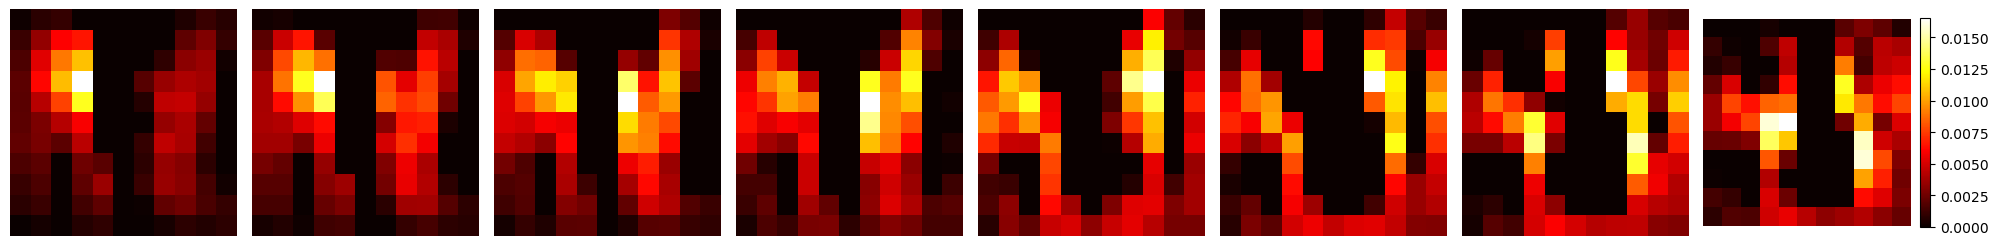

------------------------------------------------
Muestra 1007/2 Label real: 0
Predicción: Clase 0, Probabilidad: 100.0 %
Registrando Grad-CAM en capa: Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
  -->  Corte Axial (Eje Z)


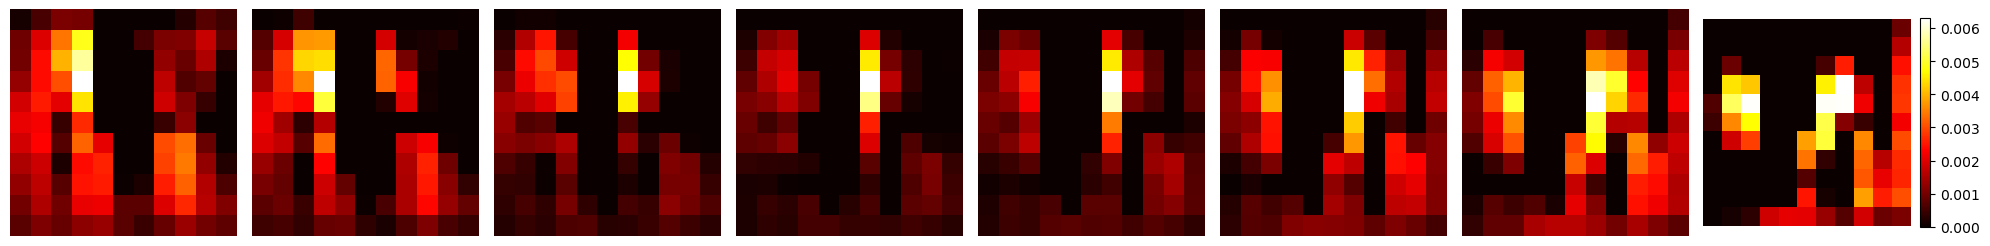

------------------------------------------------
Muestra 1013/2 Label real: 0
Predicción: Clase 0, Probabilidad: 100.0 %
Registrando Grad-CAM en capa: Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
  -->  Corte Axial (Eje Z)


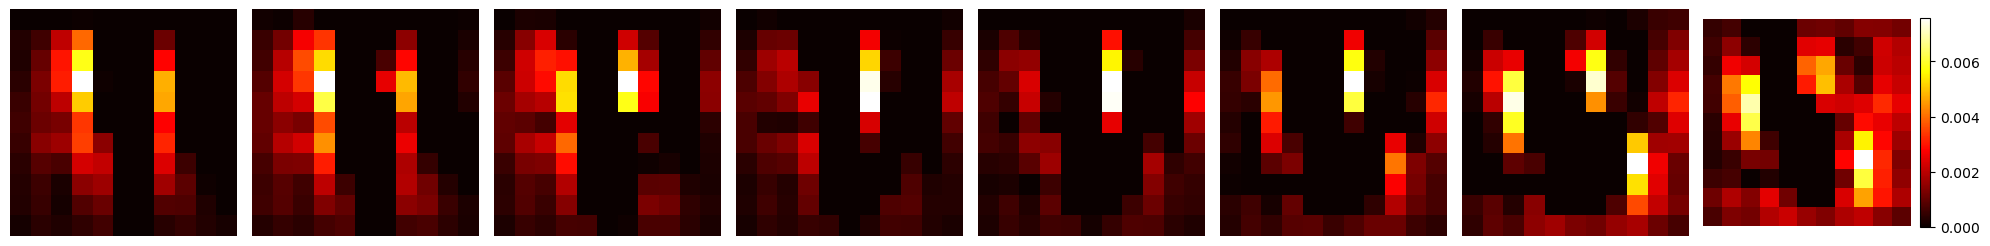

**************************************************
MUESTRAS CON TARGET = 1
**************************************************
------------------------------------------------
Muestra 1043/1 Label real: 1
Predicción: Clase 1, Probabilidad: 98.0 %
Registrando Grad-CAM en capa: Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
  -->  Corte Axial (Eje Z)


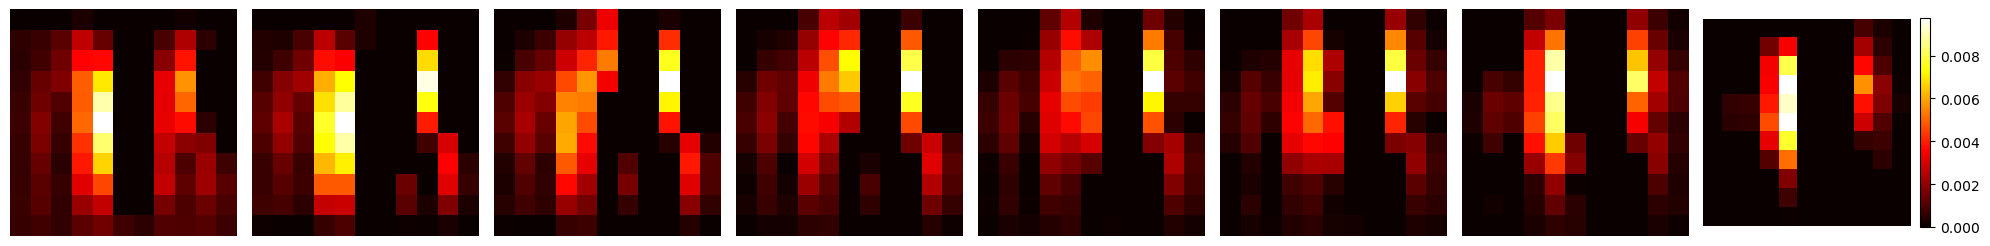

------------------------------------------------
Muestra 1084/1 Label real: 1
Predicción: Clase 1, Probabilidad: 91.5 %
Registrando Grad-CAM en capa: Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
  -->  Corte Axial (Eje Z)


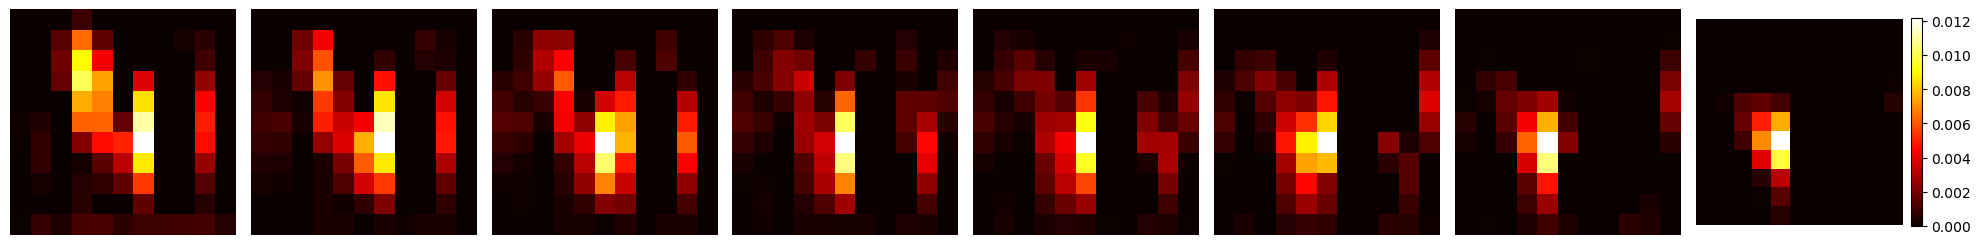

------------------------------------------------
Muestra 1200/1 Label real: 1
Predicción: Clase 1, Probabilidad: 71.4 %
Registrando Grad-CAM en capa: Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
  -->  Corte Axial (Eje Z)


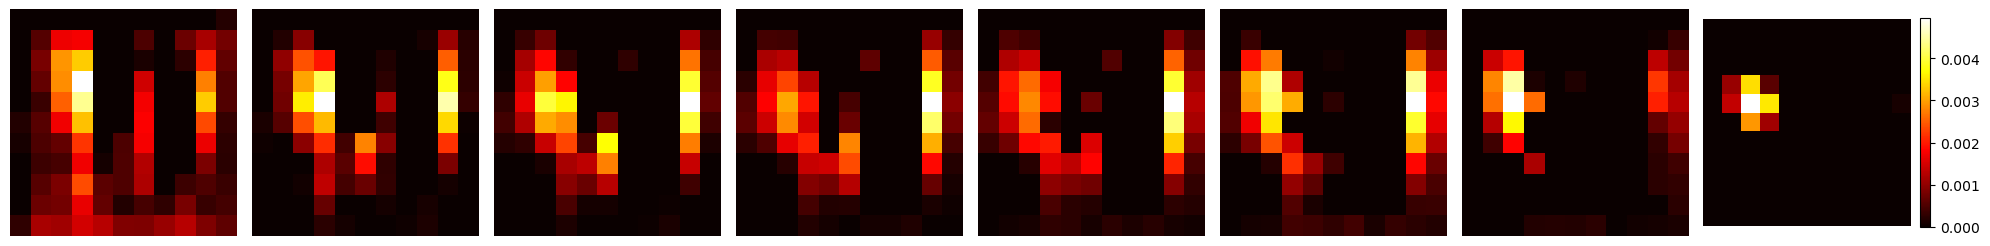

In [14]:
def analyze_Sample(model, index, axis = None, debug = False):
    sample = dataset[index]
    data, label, tipo, ID, hoja = sample
    input_tensor = data.unsqueeze(0).to(DEVICE)  # [1, 1, H, W, D]
    if debug:
        print("------------------------------------------------")
        print(f"Muestra {ID}/{hoja} Label real: {label.item()}")
    else:
        print('.', end='')
    model.to(DEVICE)
    with torch.no_grad():
        output = model(input_tensor)
        if output.shape[-1] == 1:
            output = output.squeeze(-1)
        prob = torch.sigmoid(output)[0].item()
        pred_label = int(prob >= 0.5)
        if pred_label==0:
            prob = 1 - prob
    if debug:
        print(f"Predicción: Clase {pred_label}, Probabilidad: {100* prob:.1f} %")
    
    cam = compute_gradcam_3d(model.cpu(), input_tensor.cpu(), device=DEVICE, debug = debug)
    if debug:
        if axis is None:
            for ix in range(3):
                show_gradcam_slices(cam, axis=ix)
        else:
            show_gradcam_slices(cam, axis=axis)
    return cam


############################################################
axis = 2
print('*'*50)
print('MUESTRAS CON TARGET = 0')
print('*'*50)
for i in range (3):
    analyze_Sample(model, index_0[2*i+1], axis = axis, debug = True)
print('*'*50)
print('MUESTRAS CON TARGET = 1')
print('*'*50)
for i in range (3):
    analyze_Sample(model, index_1[2*i+1],axis = axis,  debug = True)

### 3.1.4. Promediado de Grad-Cam

In [15]:
axis = 1
print('*'*50)
print('MUESTRAS CON TARGET = 0')
print('*'*50)
cam_0, cam_1 = [], []
N_Samples = 70
for i in range (N_Samples):
    cam = analyze_Sample(model, index_0[i], axis = axis, debug = False)
    cam_0.append(cam)
print()
print('*'*50)
print('MUESTRAS CON TARGET = 1')
print('*'*50)
for i in range (N_Samples):
    cam = analyze_Sample(model, index_1[i],axis = axis,  debug = False)
    cam_1.append(cam)
print()

**************************************************
MUESTRAS CON TARGET = 0
**************************************************
......................................................................
**************************************************
MUESTRAS CON TARGET = 1
**************************************************
......................................................................


  -->  Corte Sagital (Eje X)


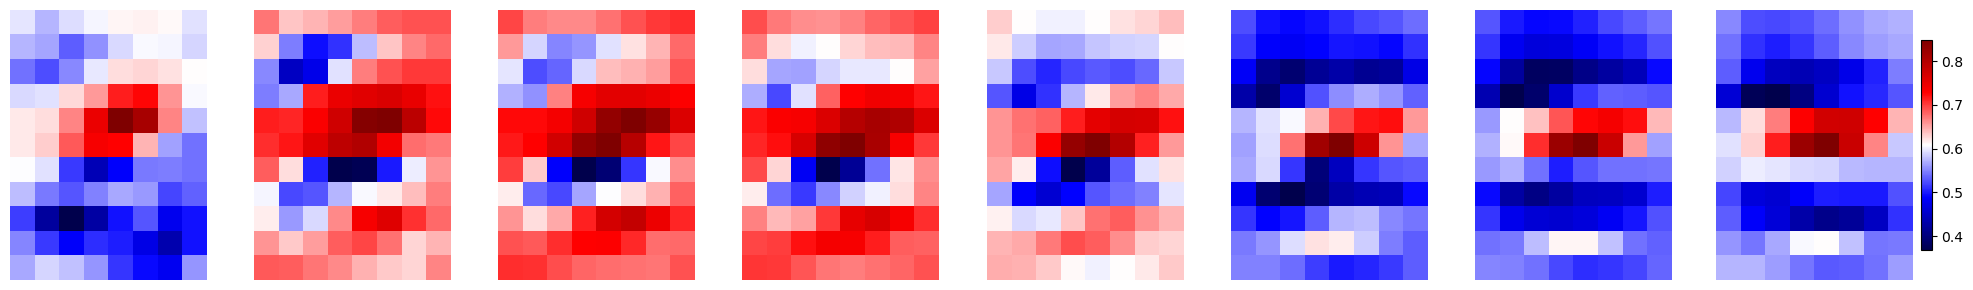

  -->  Corte Coronal (Eje Y)


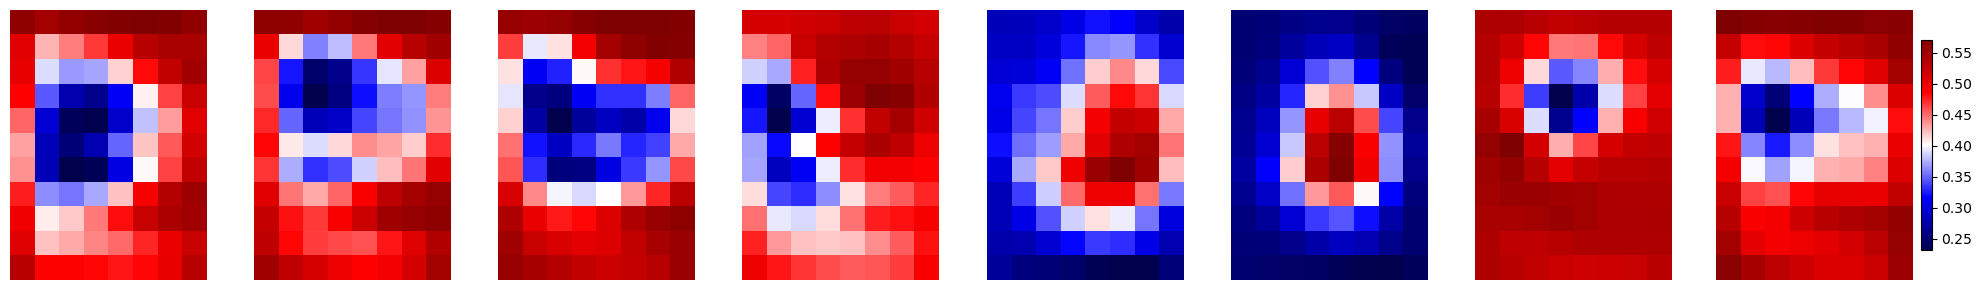

  -->  Corte Axial (Eje Z)


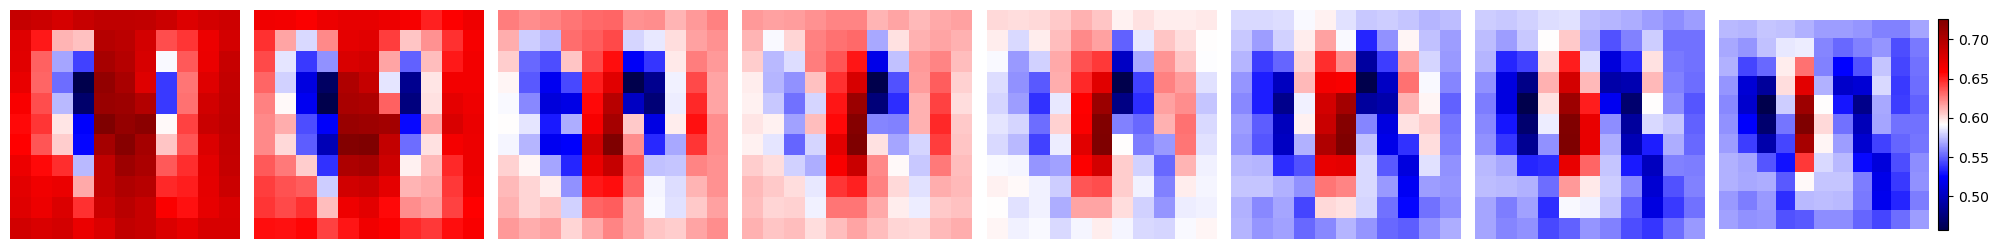

In [16]:
# Convertir listas de tensores a arrays numpy
cam_0_np = np.stack([cam.cpu().numpy() for cam in cam_0], axis=0)  # shape [N, D, H, W]
cam_1_np = np.stack([cam.cpu().numpy() for cam in cam_1], axis=0)

# Calcular el promedio por clase
cam_0_mean = cam_0_np.mean(axis=0)  # shape [D, H, W]
cam_1_mean = cam_1_np.mean(axis=0)

# Calcular la diferencia
cam_diff = cam_1_mean - cam_0_mean  # shape [D, H, W]
cam_diff = (cam_diff - cam_diff.min())/(cam_diff.max() - cam_diff.min())
for ix in range(3):
    show_gradcam_slices(cam_diff, axis=ix, cmap = 'seismic')

### 3.1.5. Superposición con Estructuras anatómicas

In [42]:
cam_diff_tensor = torch.tensor(cam_diff, dtype=torch.float32)
#img_nii = dataset.get_RawData(0)
img_nii = nib.load('sub-1003_ses-wave1_acq-FLAIR_run-1_T2w.nii.gz')

cam_diff_resized = F.interpolate(
    cam_diff_tensor,
    size=(512,512,64),
    mode='trilinear',   # interpolación lineal 3D
    align_corners=False # recomendable para interpolación trilineal
)[0,0]

cam_diff_nii = nib.Nifti1Image(cam_diff_resized.numpy(), affine=img_nii.affine)
print(img_nii.get_fdata().shape, cam_diff_nii.get_fdata().shape,cam_diff_tensor.shape)
nib.save(cam_diff_nii, 'gradcam_diff_map.nii.gz')

(512, 512, 64) (512, 512, 64) torch.Size([1, 1, 11, 11, 8])


[get_dataset_dir] Dataset found in C:\Users\juanr\nilearn_data\fsl

Región                                                Vóxeles    % Activación
--------------------------------------------------------------------------------
Temporal Pole                                            1.00         0.0000 %
Superior Temporal Gyrus, posterior division              1.00         0.0000 %
Middle Temporal Gyrus, temporooccipital part             1.00         0.0000 %
Inferior Temporal Gyrus, temporooccipital part           1.00         0.0000 %
Superior Parietal Lobule                                 1.00         0.0000 %
Frontal Medial Cortex                                    1.00         0.0000 %
Frontal Orbital Cortex                                   1.00         0.0000 %
Lingual Gyrus                                            1.00         0.0000 %
Central Opercular Cortex                                 1.00         0.0000 %
Parietal Opercular Cortex                                1.00         0.0000 %
Planum Polare                                      

C:\Users\juanr\AppData\Local\Temp\ipykernel_30308\191932841.py:37: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  thresholded_map = threshold_img(cam_diff_nii, threshold=0.003)
C:\Users\juanr\AppData\Local\Temp\ipykernel_30308\191932841.py:46: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_map = resample_to_img(thresholded_map, anat_img, interpolation='continuous')
C:\Users\juanr\.conda\envs\torch\lib\site-packages\nilearn\image\resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new beha

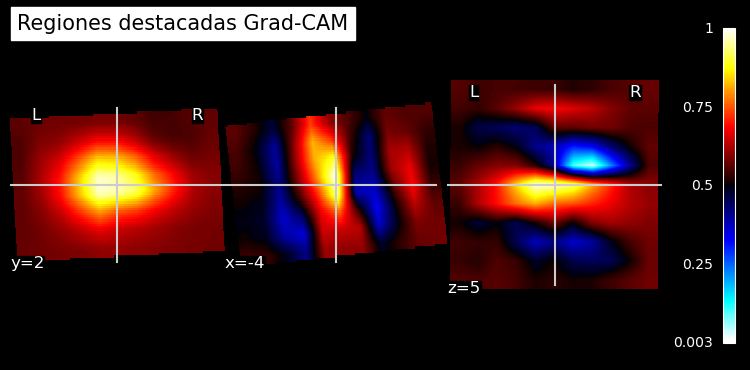

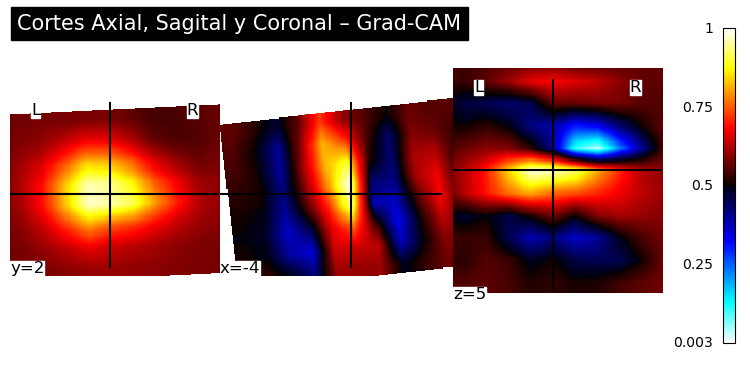

In [52]:
# Cargar atlas AAL
atlas_data = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-1mm')
atlas_nii = atlas_data.maps
atlas_labels = atlas_data.labels

activ_thresh = cam_diff_resized.numpy() > 0.5  # o el umbral que uses
activ_nii = nib.Nifti1Image(activ_thresh.astype(np.int16), affine=img_nii.affine)

# 3. Calcular intersección entre activación y regiones anatómicas
from nilearn.maskers import NiftiLabelsMasker

masker = NiftiLabelsMasker(labels_img=atlas_nii, standardize=False)
region_values = masker.fit_transform(activ_nii)

# 4. Mostrar etiquetas activadas
total_voxels = np.sum(activ_thresh)

# Guardar regiones activadas en una lista
activ_regions = []
for i, val in enumerate(region_values[0]):
    if val > 0:
        perc = 100 * val / total_voxels
        activ_regions.append((atlas_labels[i], val, perc))

# Ordenar de mayor a menor activación
activ_regions.sort(key=lambda x: x[1], reverse=True)

# Mostrar resultados
print(f"{'Región':<50} {'Vóxeles':>10} {'% Activación':>15}")
print("-" * 80)
for name, count, perc in activ_regions:
    if count>0.9:
        print(f"{name:<50} {count:>10.2f} {perc:>14.4f} %")


# Umbralizar el mapa Grad-CAM para obtener regiones de interés
thresholded_map = threshold_img(cam_diff_nii, threshold=0.003)

# Encuentra el centro de masa de regiones activadas
data = get_data(thresholded_map)
centers = center_of_mass(data, labels=data > 0)

# Convertir coordenadas voxel a MNI
mni_coords = coord_transform(centers[0], centers[1], centers[2], thresholded_map.affine)
anat_img = load_mni152_template(resolution=1)
resampled_map = resample_to_img(thresholded_map, anat_img, interpolation='continuous')

# Mostrar en viewer interactivo
plotting.plot_stat_map(thresholded_map, bg_img=anat_img, cut_coords=mni_coords,
                       display_mode='ortho', threshold=0.003, title='Regiones destacadas Grad-CAM')

plotting.plot_stat_map(
    stat_map_img=resampled_map,
    bg_img=anat_img,
    display_mode='ortho',
    cut_coords=mni_coords,
    threshold=0.003,
    cmap='cold_hot',         # Buen contraste
    colorbar=True,
    black_bg=False,          # Fondo blanco/anatómico
    dim=0.5,                 # Atenúa el fondo anatómico
    title="Cortes Axial, Sagital y Coronal – Grad-CAM"
)

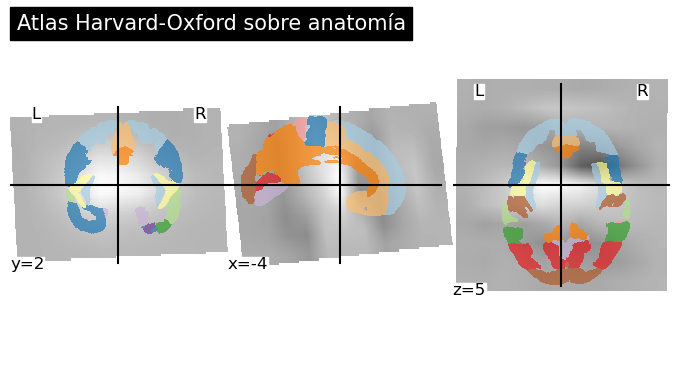

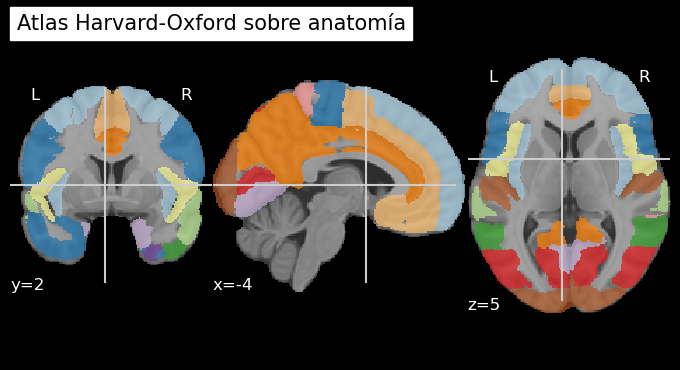

In [53]:
plotting.plot_roi(
    roi_img=atlas_nii,           # Mapa del atlas (regiones)
    bg_img=thresholded_map,             # Imagen anatómica de fondo
    title='Atlas Harvard-Oxford sobre anatomía',
    display_mode='ortho',
    cut_coords=mni_coords,
    cmap='Paired',               # Distintos colores por región
    draw_cross=True
)

plotting.plot_roi(
    roi_img=atlas_nii,           # Mapa del atlas (regiones)
    bg_img=anat_img,             # Imagen anatómica de fondo
    title='Atlas Harvard-Oxford sobre anatomía',
    display_mode='ortho',
    cut_coords=mni_coords,
    cmap='Paired',               # Distintos colores por región
    draw_cross=True
)

### 3.1.5b. Superposición con Estructuras anatómicas

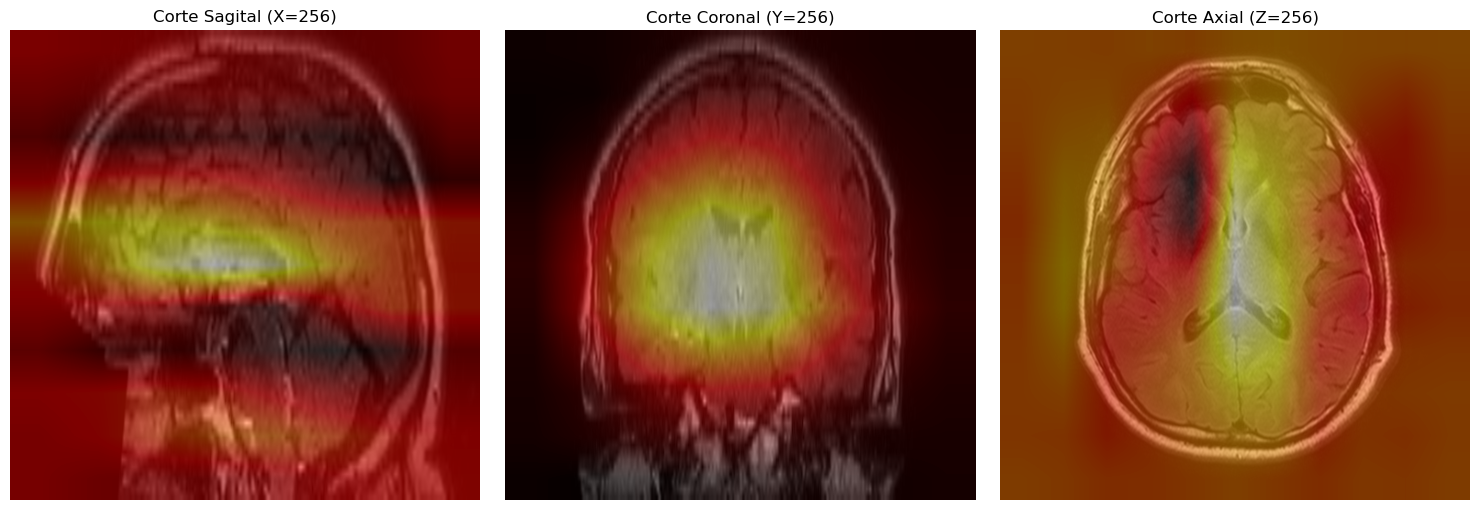

In [79]:
def Superposicion_Anatomica(cam, img_nii, shape = (512,512,512)):
    anat_tensor = torch.tensor(img_nii.get_fdata(), dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    #anat_tensor = torch.Tensor(dataset.get_RawData(0).get_fdata()).unsqueeze(0).unsqueeze(0)
    if len(anat_tensor.shape)==6:
        anat_tensor =anat_tensor[:,:,:,0]
    # Interpolación a (512, 512, 512)
    
    anat_resized = F.interpolate(
        anat_tensor, size=(512, 512, 512),
        mode='trilinear',
        align_corners=False
    )

    cam_resized = F.interpolate(
        cam, size=(512, 512, 512),
        mode='trilinear',
        align_corners=False
    )
    # Convertir de nuevo a NumPy (3D)
    anat_data = anat_resized.squeeze().cpu().numpy()
    cam_data = cam_resized.squeeze().cpu().numpy()
    
    # Calcular los cortes centrales
    center_x = anat_data.shape[0] // 2  # Sagital (eje X)
    center_y = anat_data.shape[1] // 2  # Coronal (eje Y)
    center_z = anat_data.shape[2] // 2  # Axial (eje Z)
    
    # Crear figura
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Sagital (eje X: corte en plano yz)
    axes[0].imshow(np.rot90(anat_data[center_x, :, :], k=3), cmap="gray", origin="lower")
    axes[0].imshow(np.rot90(cam_data[center_x, :, :], k=2), cmap="hot", origin="lower", alpha=0.5)
    
    axes[0].set_title(f'Corte Sagital (X={center_x})')
    axes[0].axis("off")
    
    # Coronal (eje Y: corte en plano xz)
    axes[1].imshow(np.rot90(anat_data[:, center_y, :], k = 3), cmap="gray", origin="lower")
    axes[1].imshow(np.rot90(cam_data[:, center_y, :], k=2), cmap="hot", origin="lower", alpha=0.5)
    axes[1].set_title(f'Corte Coronal (Y={center_y})')
    axes[1].axis("off")
    
    # Axial (eje Z: corte en plano xy)
    axes[2].imshow(np.rot90(anat_data[:, :, center_z], k=3), cmap="gray", origin="lower")
    axes[2].imshow(np.rot90(cam_data[:, :, center_z], k=2), cmap="hot", origin="lower", alpha=0.5)
    
    axes[2].set_title(f'Corte Axial (Z={center_z})')
    axes[2].axis("off")
    
    plt.tight_layout()
    plt.show()

Superposicion_Anatomica(cam_diff_tensor, img_nii, shape = (512,512,512))

## 3.2. Lime

### 3.2.1. Explainer

In [63]:
def predict_fn(inputs_numpy):
    """
    inputs_numpy: numpy array de shape [N, H, W, D]
    Devuelve: numpy array [N, 2] con prob de clase 0 y clase 1
    """
    model.eval()

    # Convertir a tensor
    inputs_tensor = torch.tensor(inputs_numpy, dtype=torch.float32)

    # Reordenar dimensiones: (N,H,W,D) -> (N,1,D,H,W) si tu modelo usa Conv3D
    inputs_tensor = inputs_tensor.permute(0,3,1,2).unsqueeze(1).to(DEVICE)

    outputs = []
    batch_size = 32  # ajusta según GPU
    with torch.no_grad():
        for i in range(0, inputs_tensor.shape[0], batch_size):
            batch = inputs_tensor[i:i+batch_size]
            out = model(batch.cpu()).squeeze(-1)  # [B]

            # Convertir logits a probabilidad clase positiva
            probs_1 = torch.sigmoid(out.detach()).cpu().numpy()
            probs_0 = 1 - probs_1

            # Stack en shape [B,2]
            probs = np.vstack((probs_0, probs_1)).T
            outputs.append(probs)

    outputs = np.concatenate(outputs, axis=0)
    return outputs

In [64]:
explainer = lime_image.LimeImageExplainer()

def Lime_Explanation(index):
    sample = dataset[index]
    data, label, tipo, ID, hoja = sample

    # Convertir a numpy [H,W,D]
    slice_np = data.squeeze(0).cpu().numpy()

    # Si deseas explicar un slice específico en D:
    slice_index = slice_np.shape[2] // 2
    slice_rgb = np.repeat(slice_np[:,:,slice_index][:,:,np.newaxis], 3, axis=2)

    # Explicación LIME
    explanation = explainer.explain_instance(
        slice_rgb,
        classifier_fn=predict_fn,
        top_labels=2,
        hide_color=0,
        num_samples=3000,
        segmentation_fn=lambda img: slic(img, n_segments=200, compactness=0.2, sigma=1)
    )
    return explanation, sample
    

### 3.2.2. Analisis LIME

  0%|          | 0/3000 [00:00<?, ?it/s]

Sample 1003/2: Target = 0


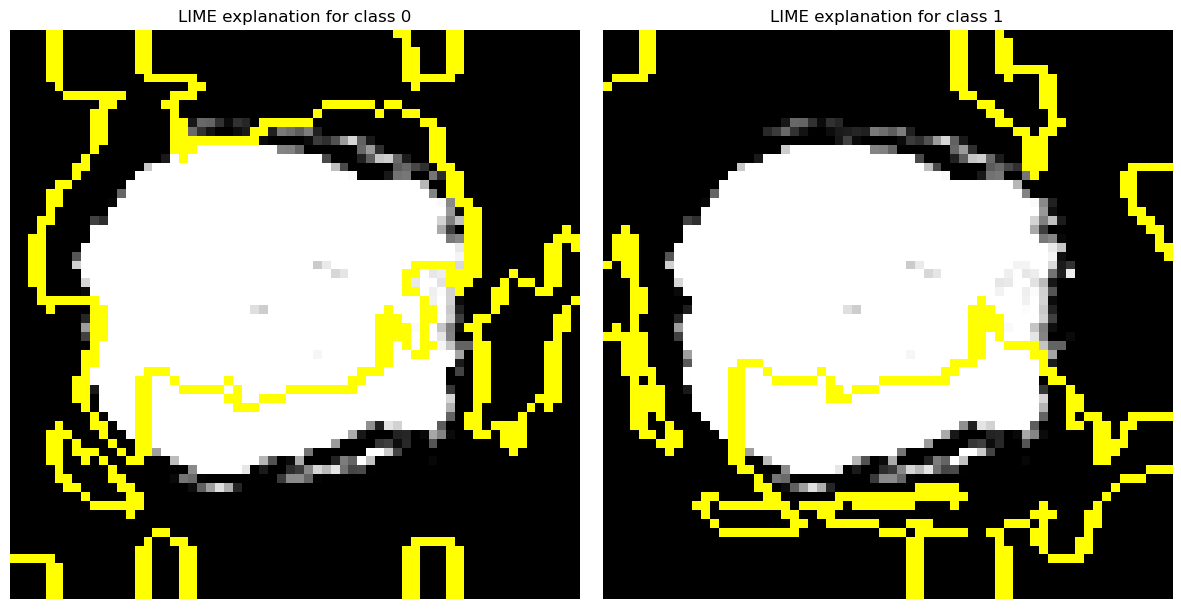

  0%|          | 0/3000 [00:00<?, ?it/s]

Sample 1007/2: Target = 0


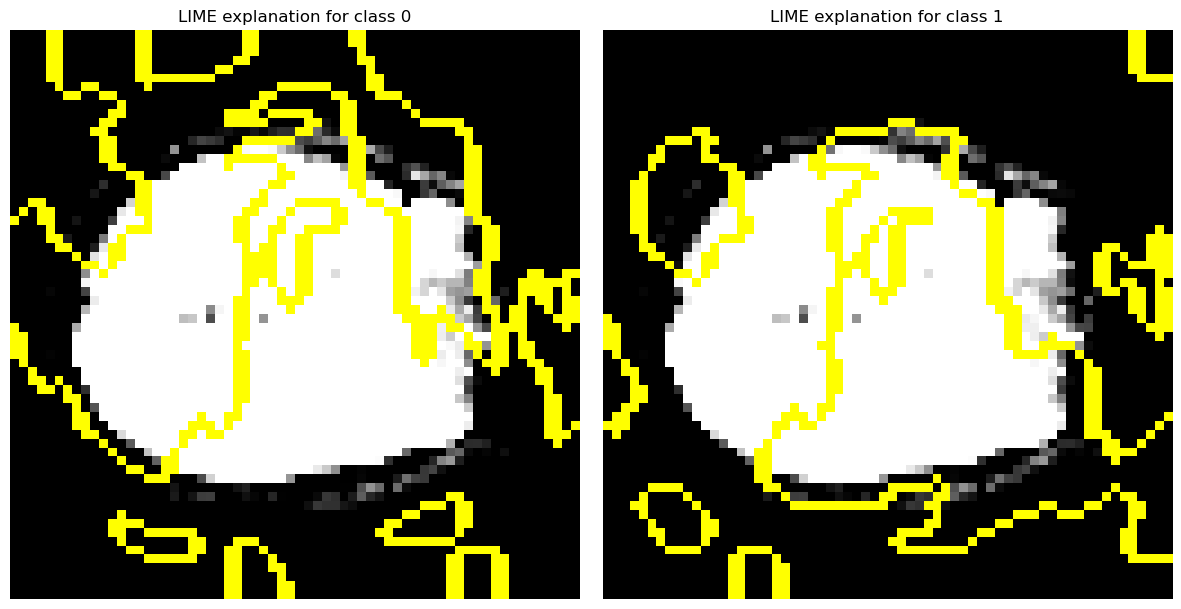

  0%|          | 0/3000 [00:00<?, ?it/s]

Sample 1007/2: Target = 0


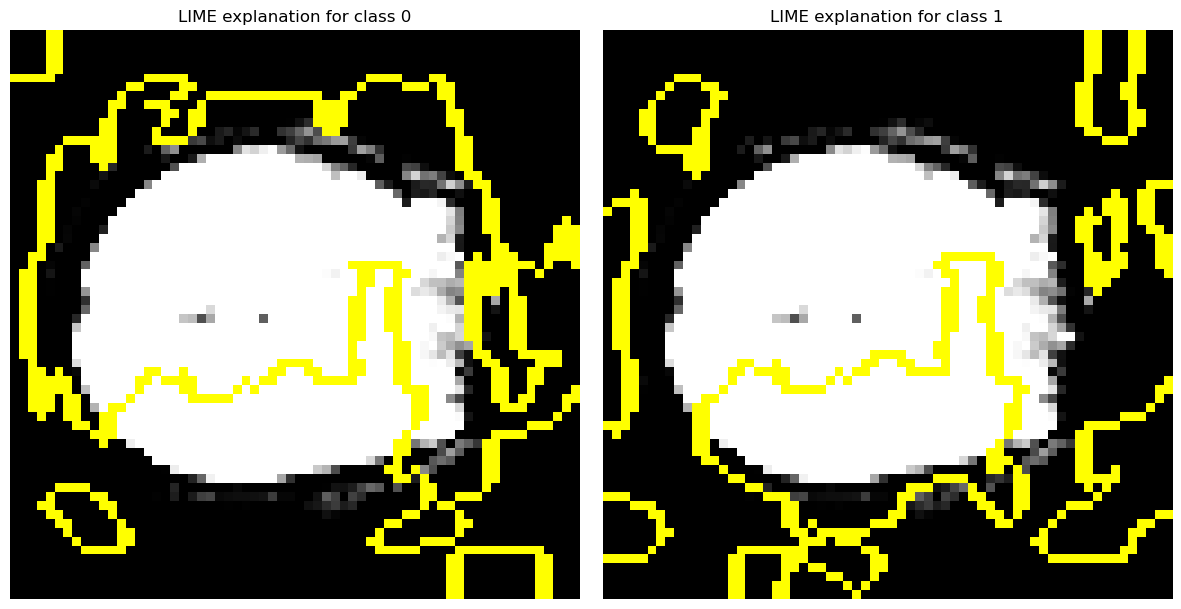

  0%|          | 0/3000 [00:00<?, ?it/s]

Sample 1043/1: Target = 1


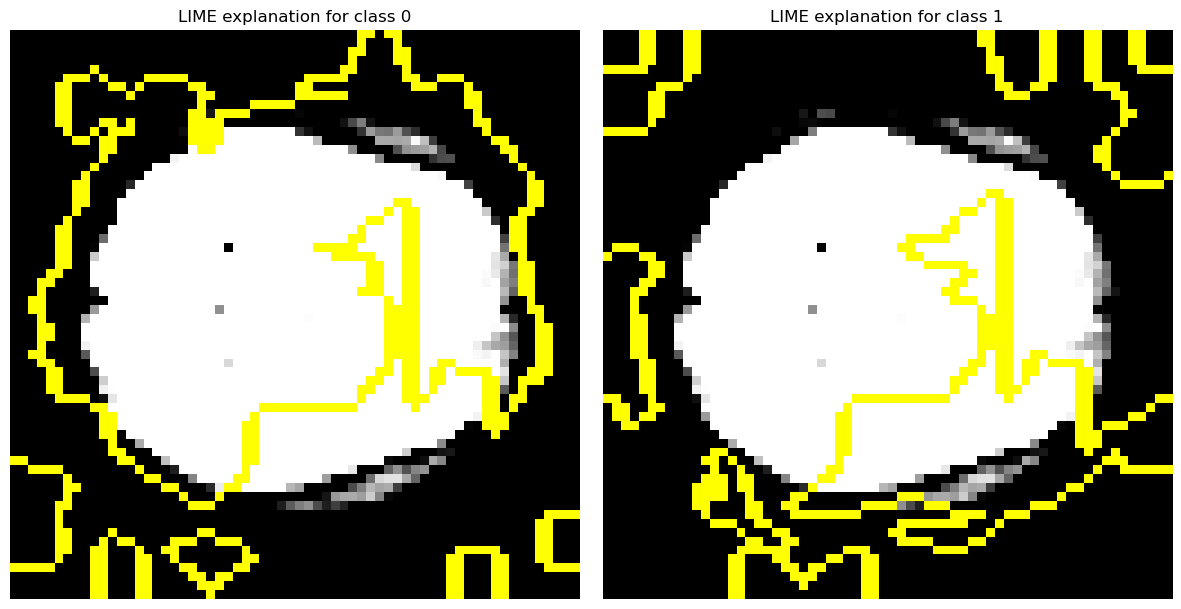

  0%|          | 0/3000 [00:00<?, ?it/s]

Sample 1084/1: Target = 1


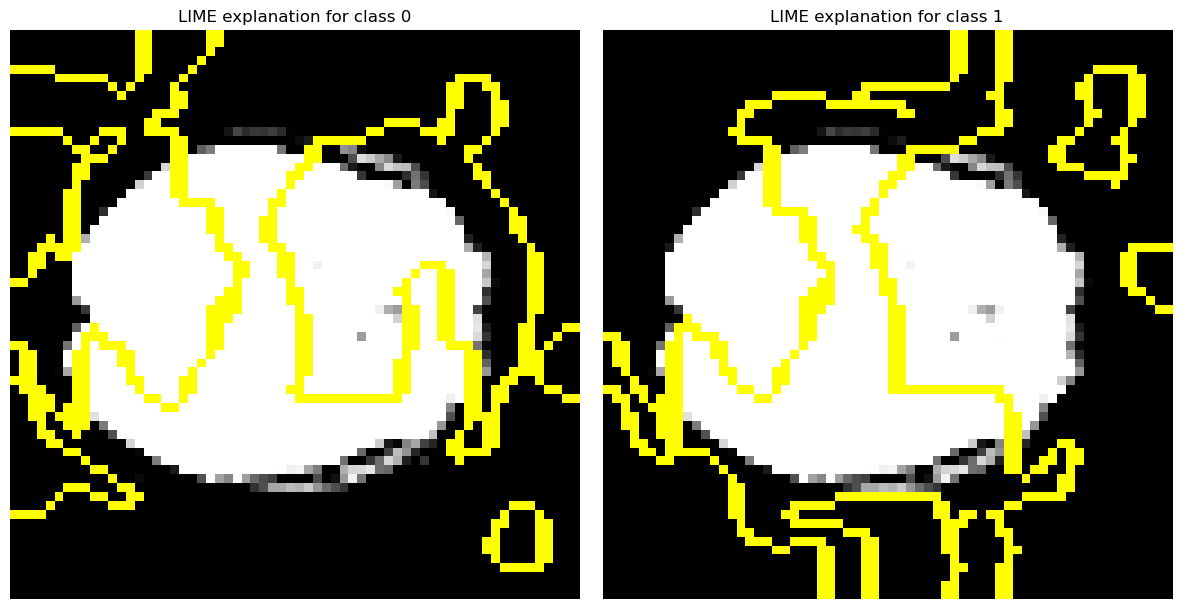

  0%|          | 0/3000 [00:00<?, ?it/s]

Sample 1084/1: Target = 1


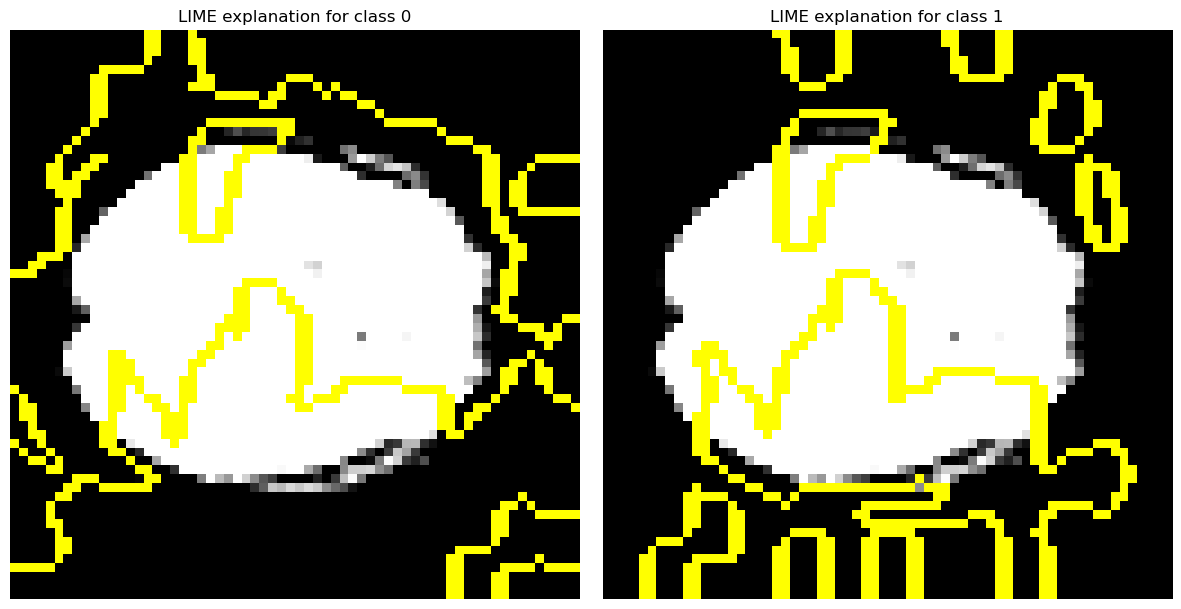

In [65]:
def Show_Explanation(indexes):    
    for index in indexes:
        explanation, sample = Lime_Explanation(index)
        print(f"Sample {sample[3]}/{sample[4]}: Target = {sample[1]}")
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))
        for idx, label_to_show in enumerate(explanation.top_labels):
            image_with_mask, mask = explanation.get_image_and_mask(
                label=label_to_show,
                positive_only=True,
                hide_rest=False,
                num_features=20,
                min_weight=0.0
            )
            image_with_mask = np.clip(image_with_mask, 0, 1)        
            axs[idx].imshow(mark_boundaries(image_with_mask, mask))
            axs[idx].set_title(f'LIME explanation for class {label_to_show}')
            axs[idx].axis('off')
        
        plt.tight_layout()
        plt.show()

model = model.cpu()
Show_Explanation(index_0[1:4])
Show_Explanation(index_1[1:4])

## 3.3. Occlusion Sensitivity

In [66]:
from tqdm import tqdm

def occlusion_sensitivity_3d(model, index, patch_size=16, stride=8, occlusion_value=0.0, device='cuda'):
    """
    Calcula el mapa de sensibilidad por oclusión para una imagen 3D.

    Parámetros:
    ------------
    model : modelo PyTorch
    input_tensor : tensor [1, 1, D, H, W]
    patch_size : tamaño del cubo a enmascarar
    stride : paso entre cubos
    occlusion_value : valor para "ocluir", e.g., 0 o valor medio
    device : 'cuda' o 'cpu'

    Retorna:
    --------
    sensitivity_map : tensor 3D [D, H, W] con score de sensibilidad
    """

    model.to(device).eval()
    sample = dataset[index]
    data, label, tipo, ID, hoja = sample
    input_tensor = data.to(device).unsqueeze(1)
    D, H, W = input_tensor.shape[2:]

    output_clean = model(input_tensor)
    prob_clean = torch.sigmoid(output_clean)[0].item()

    # Inicializar mapa acumulativo
    importance_map = torch.zeros_like(input_tensor[0, 0])

    # Contador para promedio si se solapan
    counter_map = torch.zeros_like(input_tensor[0, 0])

    for z in tqdm(range(0, D - patch_size + 1, stride), desc="Occlusion Z"):
        for y in range(0, H - patch_size + 1, stride):
            for x in range(0, W - patch_size + 1, stride):

                # Crear copia del volumen
                occluded = input_tensor.clone()

                # Aplicar oclusión
                occluded[0, 0, z:z+patch_size, y:y+patch_size, x:x+patch_size] = occlusion_value

                # Predicción
                with torch.no_grad():
                    out = model(occluded)
                    prob = torch.sigmoid(out)[0].item()

                # Sensibilidad = caída en la probabilidad de clase
                delta = prob_clean - prob

                # Acumular
                importance_map[z:z+patch_size, y:y+patch_size, x:x+patch_size] += delta
                counter_map[z:z+patch_size, y:y+patch_size, x:x+patch_size] += 1

    # Evitar divisiones por cero
    counter_map[counter_map == 0] = 1
    sensitivity_map = importance_map / counter_map

    return sensitivity_map.cpu().numpy(), prob_clean


In [67]:
sensitivity_map, base_prob = occlusion_sensitivity_3d(
    model=model,
    index=index_1[0],
    patch_size=16,
    stride=2,
    occlusion_value=0.0,
    device=DEVICE
)

print(f"Probabilidad base sin oclusión: {100*base_prob:.2f}%")
print("Esta es la probabilidad que el modelo predice originalmente para la clase positiva (clase 1) cuando se le da el volumen completo, sin alteraciones.")

Occlusion Z: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:33<00:00,  1.36s/it]

Probabilidad base sin oclusión: 97.99%
Esta es la probabilidad que el modelo predice originalmente para la clase positiva (clase 1) cuando se le da el volumen completo, sin alteraciones.


### 3.3.3. Mapa de Sensibilidad
---
Los valores positivos altos indican que al ocluir esa región, la probabilidad disminuyó mucho.
--> Esa región es muy relevante para la predicción positiva.

Los valores cercanos a cero indican que ocluir esa región no afecta la predicción, por lo que no tiene relevancia para esa clase.

Si alguna región muestra valores negativos (menos común, pero posible), significa que ocluirla aumentó la probabilidad, lo que sugiere una contribución negativa de esa región.

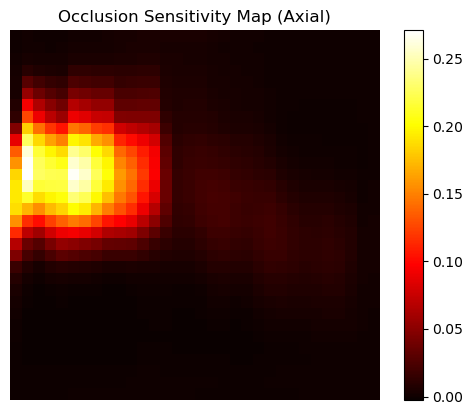

In [68]:

center_slice = sensitivity_map.shape[2] // 2  # corte axial

plt.imshow(np.rot90(sensitivity_map[:, :, center_slice]), cmap='hot', origin='lower')
plt.title("Occlusion Sensitivity Map (Axial)")
plt.colorbar()
plt.axis("off")
plt.show()


In [69]:
def plot_slices_by_step(volume, axis=2, cmap='hot', title_prefix="Slice", step=4):
    """
    Visualiza cortes equidistantes de un volumen 3D en una grilla.

    Parámetros:
    - volume: np.ndarray con forma (D, H, W) o (H, W, D)
    - axis: eje ortogonal (0=sagital, 1=coronal, 2=axial)
    - step: cada cuántos slices mostrar
    - cmap: colormap (por ejemplo, 'gray', 'hot', 'jet')
    """
    # Selección de slices
    if axis == 0:  # Sagital
        slices = [np.rot90(volume[i, :, :], k=3) for i in range(0, volume.shape[0], step)]
    elif axis == 1:  # Coronal
        slices = [np.rot90(volume[:, i, :], k=3) for i in range(0, volume.shape[1], step)]
    elif axis == 2:  # Axial
        slices = [np.rot90(volume[:, :, i], k=3) for i in range(0, volume.shape[2], step)]
    else:
        raise ValueError("axis debe ser 0, 1 o 2")

    n_slices = len(slices)
    cols = min(8, n_slices)
    rows = int(np.ceil(n_slices / cols))

    fig, axs = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    axs = axs.flatten()

    for i in range(len(axs)):
        if i < n_slices:
            axs[i].imshow(slices[i], cmap=cmap, origin='lower')
            axs[i].set_title(f"{title_prefix} {i * step}")
        axs[i].axis("off")

    plt.tight_layout()
    plt.show()


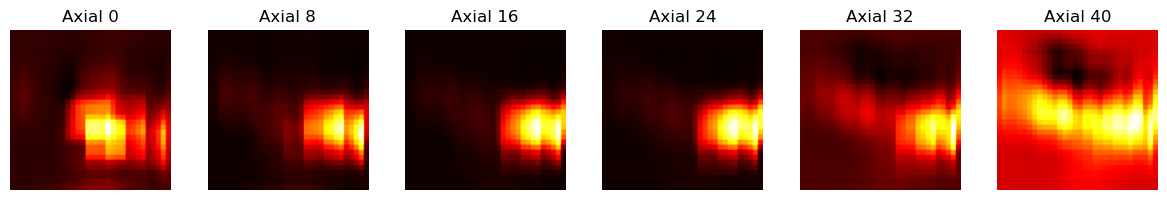

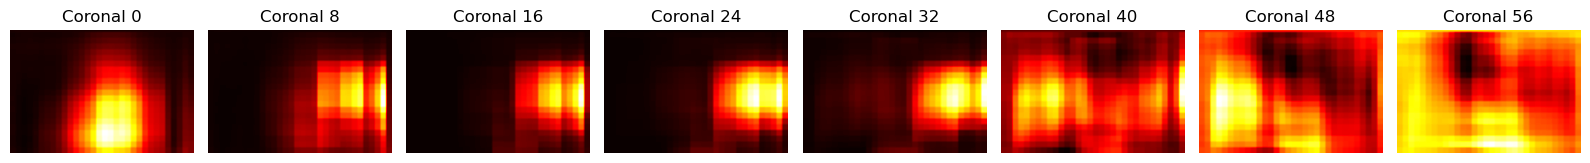

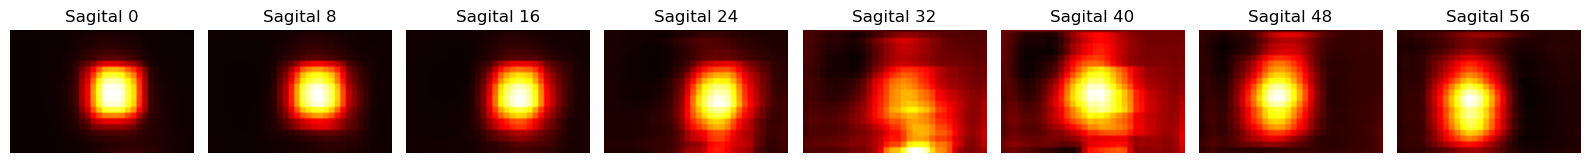

In [70]:
# Ver todos los cortes axiales
plot_slices_by_step(sensitivity_map, axis=2, cmap='hot', title_prefix='Axial', step=8)

# Cortes coronales
plot_slices_by_step(sensitivity_map, axis=1, cmap='hot', title_prefix='Coronal', step=8)

# Cortes sagitales
plot_slices_by_step(sensitivity_map, axis=0, cmap='hot', title_prefix='Sagital', step=8)

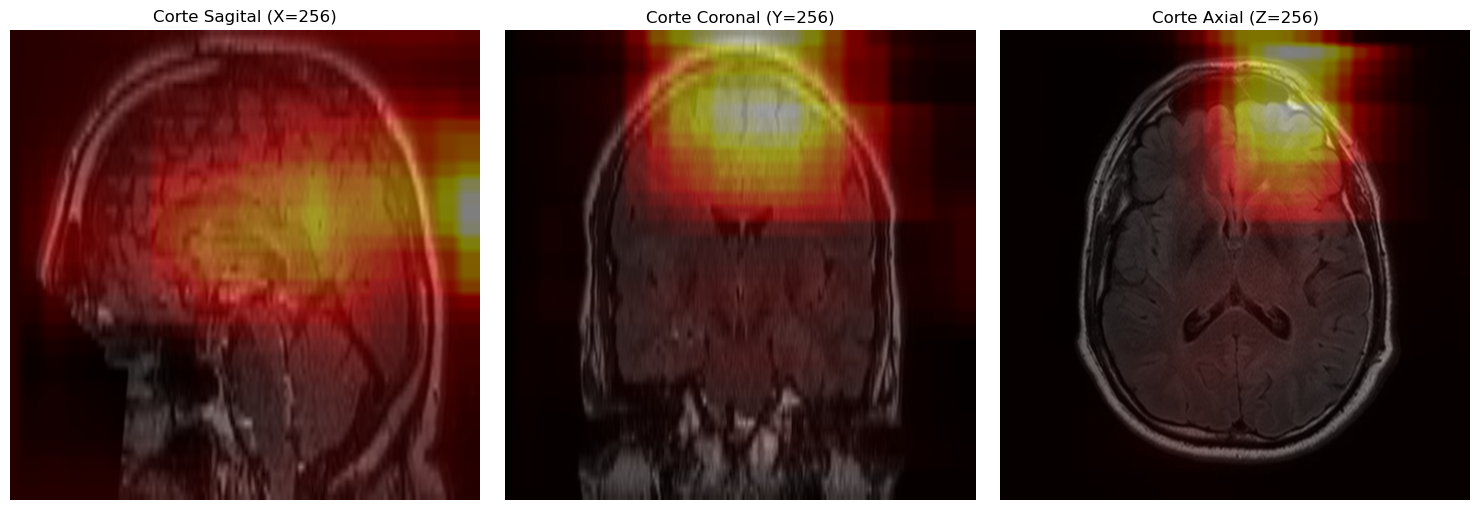

In [80]:
Superposicion_Anatomica(torch.Tensor(sensitivity_map).unsqueeze(0).unsqueeze(0), img_nii, shape = (512,512,512))